In [1]:
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")
import pandas as pd
from bs4 import BeautifulSoup as soup
import cfscrape
import json
import csv
import networkx as nx
import datetime
import glob
import network_visualizer
from datetime import datetime, timedelta
import time
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/home/diliadis/anaconda3/envs/flight_radar_env/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from folium import Map
from folium.plugins import HeatMap

In [3]:
airports_df = pd.read_csv('airports_data/flight_radar_24_airports.csv', sep=',')

european_airports_df = pd.read_csv('airports_data/european_airports.csv', sep=',')

delays_df = pd.read_csv('delays/departure_arival_delays20_Jan_2021.csv', sep=',')

In [4]:
european_airport_codes_list = european_airports_df['IATA'].tolist()

In [5]:
airports_df

,Id,City,Country,Label,Name,latitude,longitude
0,0,Linz,AUSTRIA,LNZ,Linz Airport,48.233212,14.187510
1,1,Vienna,AUSTRIA,VIE,Vienna International Airport,48.110271,16.569719
2,2,Brussels,BELGIUM,BRU,Brussels Airport,50.901379,4.484444
3,3,Sofia,BULGARIA,SOF,Sofia Airport,42.695190,23.406160
4,4,Paris,FRANCE,ORY,Paris Orly Airport,48.723331,2.379444
...,...,...,...,...,...,...,...
993,993,White Plains,UNITED STATES,HPN,White Plains Westchester County Airport,41.066940,-73.707497
994,994,Grenoble,FRANCE,GNB,Grenoble Isere Airport,45.363049,5.332778
995,995,Dundee,UNITED KINGDOM,DND,Dundee Airport,56.452492,-3.025830
996,996,Oklahoma City,UNITED STATES,OKC,Oklahoma City Will Rogers World Airport,35.393082,-97.600700


In [6]:
delays_df

,Unnamed: 0,from_airports_list,to_airports_list,departure_delay_time_list,departure_delay_list,arrival_delay_time_list,arrival_delay_list,flight_code_list
0,0,TIA,BRU,-586.0,True,686.0,False,TB2952
1,1,BRU,TIA,-746.0,True,590.0,False,TB2951
2,2,ATH,TIA,-973.0,True,-71.0,True,A3970
3,3,TIA,BGY,-21622.0,True,-19969.0,True,ZB2007
4,4,BGY,TIA,-20948.0,True,-20164.0,True,ZB2008
...,...,...,...,...,...,...,...,...
5858,5858,GCI,SOU,-713.0,True,573.0,False,GR656
5859,5859,SOU,JER,-327.0,True,303.0,False,SI3371
5860,5860,JER,SOU,-195.0,True,809.0,False,SI3370
5861,5861,NCL,AMS,19.0,False,1218.0,False,KL954


In [7]:
departures_delays_list = []
arrivals_delays_list = []

airports_dict = {}
for index, row in airports_df.iterrows():
    airports_dict[row['Label']] = (row['latitude'], row['longitude'])

In [8]:
airports_dict

{'LNZ': (48.233212, 14.187510000000001),
 'VIE': (48.110271000000004, 16.569719),
 'BRU': (50.901379, 4.484444),
 'SOF': (42.695190000000004, 23.40616),
 'ORY': (48.723331, 2.379444),
 'CGN': (50.866001000000004, 7.143),
 'FRA': (50.026421, 8.543125),
 'MUC': (48.353778999999996, 11.78608),
 'ATH': (37.936352, 23.94446),
 'BUD': (47.436932, 19.255589999999998),
 'AOI': (43.616341, 13.36231),
 'BRI': (41.138851, 16.76059),
 'BLQ': (44.535439000000004, 11.28866),
 'FLR': (43.809952, 11.2051),
 'GOA': (44.41333, 8.8375),
 'BGY': (45.673882, 9.704166),
 'MXP': (45.6306, 8.728111),
 'PEG': (43.095901, 12.51322),
 'PSA': (43.68391, 10.39275),
 'RMI': (44.02029, 12.61174),
 'FCO': (41.80447, 12.25079),
 'TSF': (45.648399, 12.19442),
 'TRN': (45.200759999999995, 7.649630999999999),
 'CUF': (44.547009, 7.6232169999999995),
 'VCE': (45.505268, 12.351939999999999),
 'VRN': (45.395699, 10.888530000000001),
 'AMS': (52.308609000000004, 4.763889),
 'BEG': (44.818439, 20.30913),
 'LJU': (46.223679, 1

In [9]:
for index, row in delays_df.iterrows():
    if row['departure_delay_list']:
        if (row['from_airports_list'] in airports_dict.keys()) and (row['from_airports_list'] in european_airport_codes_list):
            lat, longt = airports_dict[row['from_airports_list']]
            departures_delays_list.append((lat, longt, abs(float(row['departure_delay_time_list']))))

    if row['arrival_delay_list']:
        if (row['to_airports_list'] in airports_dict.keys()) and (row['to_airports_list'] in european_airport_codes_list):
            lat, longt = airports_dict[row['to_airports_list']]
            arrivals_delays_list.append((lat, longt, abs(float(row['arrival_delay_time_list']))))

In [10]:
departures__map = Map(location=[48.499998, 23.3833318], zoom_start=4, )

In [11]:
departures_layer = HeatMap(departures_delays_list,
                  min_opacity=0.9,
                  radius=17, 
                  blur=25, 
                  max_zoom=5,
)

In [12]:
departures__map.add_child(departures_layer)

In [13]:
arrivals__map = Map(location=[48.499998, 23.3833318], zoom_start=4, )

In [14]:
arrivals_layer = HeatMap(arrivals_delays_list,
                  min_opacity=0.2,
                  radius=17, 
                  blur=15, 
                  max_zoom=1,
)

In [16]:
arrivals__map.add_child(departures_layer)

In [ ]:
#just calculate the average departure and arrival delay of every airport and then create the heatmaps again

In [17]:
average_departure_delay_per_airport = {}
average_arrival_delay_per_airport = {}

In [18]:
# for every airport gather all the departure and arrival delays
for index, row in delays_df.iterrows():
    if row['departure_delay_list']:
        if row['from_airports_list'] in airports_dict.keys() and row['from_airports_list'] in european_airport_codes_list:
            if row['from_airports_list'] not in average_departure_delay_per_airport.keys():
                average_departure_delay_per_airport[row['from_airports_list']] = []
            average_departure_delay_per_airport[row['from_airports_list']].append(abs(float(row['departure_delay_time_list'])))
    if row['arrival_delay_list']:
        if row['to_airports_list'] in airports_dict.keys() and row['to_airports_list'] in european_airport_codes_list:
            if row['to_airports_list'] not in average_arrival_delay_per_airport.keys():
                average_arrival_delay_per_airport[row['to_airports_list']] = []
            average_arrival_delay_per_airport[row['to_airports_list']].append(abs(float(row['arrival_delay_time_list'])))

In [19]:
average_departures_delays_per_coordinates = []
for key, delays_list in average_departure_delay_per_airport.items():
    if key in airports_dict.keys():
        lat, longt = airports_dict[key]
        average_departures_delays_per_coordinates.append((lat, longt, np.mean(delays_list)))

In [20]:
average_arrivals_delays_per_coordinates = []
for key, delays_list in average_arrival_delay_per_airport.items():
    if key in airports_dict.keys():
        lat, longt = airports_dict[key]
        average_arrivals_delays_per_coordinates.append((lat, longt, np.mean(delays_list)))

In [21]:
len(average_departures_delays_per_coordinates)

171

In [22]:
average_departures_delays_per_coordinates

[(41.414742, 19.72056, 7483.333333333333),
 (50.901379, 4.484444, 1550.0294117647059),
 (37.936352, 23.94446, 677.984375),
 (45.673882, 9.704166, 6138.625),
 (40.898548, 29.309209999999997, 1076.078947368421),
 (53.882462, 28.030728999999997, 1424.8857142857144),
 (55.591530000000006, 37.261478000000004, 1502.6746987951808),
 (46.991058, 15.439620000000001, 564.0),
 (48.110271000000004, 16.569719, 1630.1694915254238),
 (34.875111, 33.624851, 856.2),
 (55.608387, 12.645351, 801.2972972972973),
 (49.012516, 2.555752, 1168.3010752688172),
 (51.289452000000004, 6.766775, 1437.1875),
 (50.026421, 8.543125, 1712.7337278106509),
 (53.630379000000005, 9.988228, 1152.7272727272727),
 (48.353778999999996, 11.78608, 959.6136363636364),
 (45.6306, 8.728111, 2748.3947368421054),
 (42.572769, 21.035829999999997, 815.8571428571429),
 (49.623329, 6.2044440000000005, 2021.8181818181818),
 (52.308609000000004, 4.763889, 1045.2485207100592),
 (52.165749, 20.967119, 1118.6410256410256),
 (44.818439, 20.30

In [23]:
max([i[2] for i in average_departures_delays_per_coordinates])

23326.0

In [24]:
from matplotlib import pyplot as plt

(array([164.,   5.,   1.,   0.,   1.]),
 array([7.00000e+00, 4.67080e+03, 9.33460e+03, 1.39984e+04, 1.86622e+04,
        2.33260e+04]),
 <a list of 5 Patch objects>)

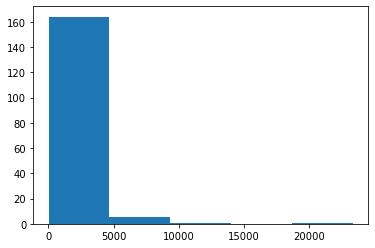

In [25]:
plt.hist([i[2] for i in average_departures_delays_per_coordinates], 5)

In [26]:
average_departures__map = Map(location=[48.499998, 23.3833318], zoom_start=4, )

average_departures_layer = HeatMap(average_departures_delays_per_coordinates,
                  max_val=max([i[2] for i in average_departures_delays_per_coordinates]),
                  min_opacity=0.2,
                  radius=20, 
                  blur=1, 
                  max_zoom=1,
)

In [27]:
average_departures__map.add_child(average_departures_layer)

(array([124.,   4.,   2.,   2.,   3.]),
 array([1.40000e+01, 4.81720e+03, 9.62040e+03, 1.44236e+04, 1.92268e+04,
        2.40300e+04]),
 <a list of 5 Patch objects>)

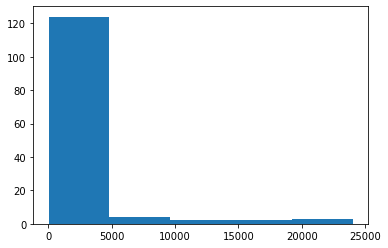

In [29]:
plt.hist([i[2] for i in average_arrivals_delays_per_coordinates], 5)

In [30]:
average_arrivals__map = Map(location=[48.499998, 23.3833318], zoom_start=4, )

average_arrivals_layer = HeatMap(average_arrivals_delays_per_coordinates,
                  max_val=max([i[2] for i in average_arrivals_delays_per_coordinates]),
                  min_opacity=0.2,
                  radius=20, 
                  blur=1, 
                  max_zoom=1,
)

In [31]:
average_arrivals__map.add_child(average_arrivals_layer)

In [33]:
canceled_flights_df = pd.read_csv('canceled_flights/canceled_flights_on_20_Jan_2021.csv', sep=',')

In [34]:
canceled_flights_df

,Unnamed: 0,canceled_departure_list,canceled_arrival_list,canceled_flight_codes_list
0,0,SHJ,EVN,G9244
1,1,EVN,SHJ,G9245
2,2,VIE,TLV,3V4848
3,3,VIE,TLV,3V4848
4,4,VIE,SHJ,G9572
...,...,...,...,...
181,181,CMN,LHR,AT800
182,182,DXB,LHR,EK7
183,183,ORD,LHR,BA294
184,184,STN,OPO,FR8343


In [35]:
average_canceled_flight = {}

In [36]:
airports_dict = {}
for index, row in airports_df.iterrows():
    airports_dict[row['Label']] = (row['latitude'], row['longitude'])

In [37]:
# for every airport gather all the departure and arrival delays
for index, row in canceled_flights_df.iterrows():
    if row['canceled_departure_list'] in airports_dict.keys() and row['canceled_departure_list'] in european_airport_codes_list:
        if row['canceled_departure_list'] not in average_canceled_flight.keys():
            average_canceled_flight[row['canceled_departure_list']] = 0
        average_canceled_flight[row['canceled_departure_list']] += 1

In [38]:
average_canceled_flight

{'VIE': 8,
 'AMS': 9,
 'GYD': 2,
 'SOF': 2,
 'FRA': 3,
 'AAL': 4,
 'CPH': 17,
 'AAR': 2,
 'DUS': 2,
 'MUC': 2,
 'GDN': 2,
 'ARN': 2,
 'HEL': 4,
 'LHR': 7,
 'AJA': 2,
 'MRS': 4,
 'BIA': 2,
 'MPL': 1,
 'CDG': 5,
 'TBS': 1,
 'MLA': 3,
 'BLQ': 2,
 'FCO': 4,
 'FLR': 2,
 'MXP': 1,
 'ALA': 1,
 'OSL': 6,
 'ABZ': 2,
 'EDI': 2,
 'GLA': 2,
 'BGO': 2,
 'WAW': 1,
 'LIS': 1,
 'OPO': 2,
 'STN': 2,
 'SVX': 1,
 'DME': 2,
 'AER': 4,
 'SVO': 3,
 'IST': 6,
 'BIO': 2,
 'ZAZ': 2,
 'ZRH': 1,
 'ESB': 1,
 'LGW': 1}